<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *
import feather

In [4]:
PATH = 'data/elo/'

In [5]:
dep = 'target'
df_raw = feather.read_dataframe('train_df')

In [6]:
df_test = feather.read_dataframe('test_df')

In [7]:
# df_raw.drop('outliers', axis=1, inplace=True)

In [8]:
df_indep = df_raw.drop(dep,axis=1)
n_valid = 12000
n_trn = len(df_raw)-n_valid

In [9]:
cat_flds = [n for n in df_indep.columns if df_raw[n].nunique()<50 and n != 'outliers']
' '.join(cat_flds)

'feature_1 feature_2 feature_3 first_active_monthYear first_active_monthMonth first_active_monthWeek first_active_monthDay first_active_monthDayofweek first_active_monthDayofyear first_active_monthIs_month_end first_active_monthIs_month_start first_active_monthIs_quarter_end first_active_monthIs_quarter_start first_active_monthIs_year_end first_active_monthIs_year_start city_id_nunique merchant_category_id_nunique state_id_nunique subsector_id_nunique purchase_Year_nunique purchase_Month_nunique purchase_Week_nunique purchase_Day_nunique installments_max installments_min month_lag_max month_lag_min authorized_flag_mean purchased_on_weekend_sum category_1_sum state_id_nunique_old subsector_id_nunique_old purchase_Year_nunique_old purchase_Month_nunique_old purchase_Day_nunique_old installments_max_old installments_min_old month_lag_max_old month_lag_min_old'

In [10]:
len(cat_flds)

39

In [11]:
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

['first_active_month',
 'card_id',
 'purchase_date_max',
 'purchase_date_min',
 'purchase_date_max_old',
 'purchase_date_min_old']

In [12]:
for df in [df_raw, df_indep, df_test]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old', 'first_active_month']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [13]:
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

['card_id']

In [14]:
df_indep.drop('card_id', axis=1, inplace=True)
df_test.drop('card_id', axis=1, inplace=True)

In [15]:
for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered()

cont_flds = [n for n in df_indep.columns if n not in cat_flds and n!= 'outliers']
' '.join(cont_flds)

'first_active_month first_active_monthElapsed transactions_count merchant_id_nunique purchase_amount_sum purchase_amount_max purchase_amount_min purchase_amount_mean purchase_amount_var installments_sum installments_mean installments_var purchase_date_max purchase_date_min month_lag_mean month_lag_var month_diff_mean month_diff_std month_diff_var authorized_flag_sum purchased_on_weekend_mean category_1_mean card_id_size card_id_count category_2_mean_mean category_3_mean_mean purchase_date_diff purchase_date_average purchase_date_uptonow purchase_date_uptomin inverse_avg_transactions_per_day days_since_last_transaction repurchase_merchant_rate merchant_category_repurchase avg_spend_per_merchant avg_trans_per_merchant avg_spend_per_transaction transactions_count_old city_id_nunique_old merchant_category_id_nunique_old merchant_id_nunique_old purchase_Week_nunique_old purchase_amount_sum_old purchase_amount_max_old purchase_amount_min_old purchase_amount_mean_old purchase_amount_var_old i

In [16]:
df_raw = df_raw[cat_flds+cont_flds+[dep]]
df, y, nas, mapper = proc_df(df_raw, 'target', do_scale=True)

val_idx = list(range(n_trn, len(df)))

In [17]:
df_t, _, nas, mapper = proc_df(df_test, do_scale=True, mapper=mapper)

In [18]:
df.shape, df_t.shape

((201917, 173), (123623, 201))

In [19]:
apply_cats(df_t, df)

In [20]:
df_t = df_t[df.columns.values]

In [21]:
df_t.shape, df.shape

((123623, 173), (201917, 173))

In [22]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64, test_df=df_t)

In [23]:
# df.head().T

In [24]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [25]:
emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c

{'feature_1': 6,
 'feature_2': 4,
 'feature_3': 3,
 'first_active_monthYear': 9,
 'first_active_monthMonth': 13,
 'first_active_monthWeek': 22,
 'first_active_monthDay': 2,
 'first_active_monthDayofweek': 8,
 'first_active_monthDayofyear': 23,
 'first_active_monthIs_month_end': 2,
 'first_active_monthIs_month_start': 2,
 'first_active_monthIs_quarter_end': 2,
 'first_active_monthIs_quarter_start': 3,
 'first_active_monthIs_year_end': 2,
 'first_active_monthIs_year_start': 3,
 'city_id_nunique': 27,
 'merchant_category_id_nunique': 40,
 'state_id_nunique': 14,
 'subsector_id_nunique': 25,
 'purchase_Year_nunique': 3,
 'purchase_Month_nunique': 3,
 'purchase_Week_nunique': 11,
 'purchase_Day_nunique': 31,
 'installments_max': 16,
 'installments_min': 15,
 'month_lag_max': 3,
 'month_lag_min': 3,
 'authorized_flag_mean': 2,
 'purchased_on_weekend_sum': 40,
 'category_1_sum': 17,
 'state_id_nunique_old': 21,
 'subsector_id_nunique_old': 35,
 'purchase_Year_nunique_old': 3,
 'purchase_Month

In [26]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
metrics=[rmse]

In [27]:
y_range=(np.min(y)*1,np.max(y)*1.2)

In [28]:
emb_szs

[(6, 3),
 (4, 2),
 (3, 2),
 (9, 5),
 (13, 7),
 (22, 11),
 (2, 1),
 (8, 4),
 (23, 12),
 (2, 1),
 (2, 1),
 (2, 1),
 (3, 2),
 (2, 1),
 (3, 2),
 (27, 14),
 (40, 20),
 (14, 7),
 (25, 13),
 (3, 2),
 (3, 2),
 (11, 6),
 (31, 16),
 (16, 8),
 (15, 8),
 (3, 2),
 (3, 2),
 (2, 1),
 (40, 20),
 (17, 9),
 (21, 11),
 (35, 18),
 (3, 2),
 (12, 6),
 (32, 16),
 (15, 8),
 (11, 6),
 (13, 7),
 (14, 7)]

In [29]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_flds),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 3]),
                           ('trainable', True),
                           ('nb_params', 18)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 6)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 5]),
                           ('trainable', True),
                           ('nb_params', 45)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1]),
   

In [30]:
# m = md.get_learner(emb_szs, len(cont_flds), 0.05, 1, [500,250], [0.5,0.05],
#                    y_range=y_range, use_bn=True)

In [31]:
len(cat_flds)

39

In [32]:
len(cont_flds)

93

In [33]:
m.lr_find()

 67%|██████▋   | 1980/2968 [00:09<00:04, 201.91it/s, loss=14.9]


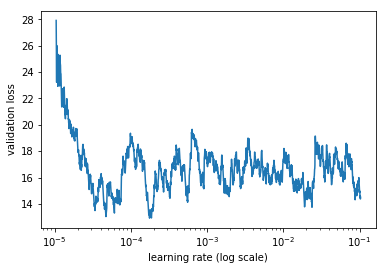

In [34]:
m.sched.plot()

In [35]:
lr=1e-4; wd=1e-7

In [36]:
%time m.fit(lr, 2, wd, cycle_len=1, cycle_mult=2, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                          
    0      11.792236  14.630858  3.632619  
    1      13.391654  14.670274  3.632905                      
    2      14.64457   14.287193  3.588186                      

CPU times: user 47.1 s, sys: 809 ms, total: 47.9 s
Wall time: 47.1 s


[array([14.28719]), 3.5881859476114673]

In [40]:
m(VV(df_t.values))

NotImplementedError: object

In [42]:
torch.__version__

'0.3.1.post2'

In [39]:
cds = ColumnarDataset.from_data_frame(df_t,cat_flds=cat_flds)
dl = DataLoader(cds)
predictions = m.predict_dl(dl)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/THCGeneral.c:844

In [38]:
m.predict_array(df_t[cat_flds].values, df_t[cont_flds].values)

NotImplementedError: object

In [37]:
l = m.predict(is_test=True)

RuntimeError: CUDNN_STATUS_MAPPING_ERROR

In [35]:
%time m.fit(lr, 2, wd, cycle_len=2, cycle_mult=2, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                          
    0      14.133671  14.354443  3.60765   
    1      15.588344  14.0994    3.566478                      
    2      12.785697  14.255085  3.587347                      
    3      14.796533  14.078996  3.569934                      
    4      12.458841  14.010397  3.554966                      
    5      11.36335   13.932619  3.547807                      

CPU times: user 1min 35s, sys: 1.57 s, total: 1min 37s
Wall time: 1min 35s


[array([13.93262]), 3.547806560692376]

In [36]:
from sklearn.model_selection import StratifiedKFold

In [37]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_raw))
predictions = np.zeros(len(df_test))

In [38]:
outliers = df_indep['outliers']

In [39]:
target = df_raw['target']

In [40]:
val_idx[:5]

[189917, 189918, 189919, 189920, 189921]

1. Get the val_idx
2. Get the model data set 
`ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64)`
3. Get the learner from model `md.get_learner(`
4. Fit the model `m.fit`

In [41]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df, outliers.values)):
    print("fold {}".format(fold_))
    md = ColumnarModelData.from_data_frame(PATH, val_idx, df, target.astype(np.float32), 
                                           cat_flds=cat_flds, bs=128, test_df=df_t)
    m = md.get_learner(emb_szs, len(df.columns)-len(cat_flds),
                   0.04, 1, [1000,500, 1000], [0.001,0.01, 0.001], y_range=y_range)
    m.fit(lr, 2, wd, cycle_len=2, cycle_mult=1, metrics=[rmse])
    oof[val_idx] = m.predict().reshape(1, -1)[0]
#     predictions += m.predict(is_test=True) / folds.n_splits

np.sqrt(rmse(oof, target))

fold 0


epoch      trn_loss   val_loss   rmse                          
    0      15.816438  14.411224  3.706317  
    1      14.104812  14.113045  3.669662                      
    2      12.336802  13.963231  3.645694                      
    3      13.035529  13.812777  3.631148                      

fold 1


epoch      trn_loss   val_loss   rmse                          
    0      14.392886  14.395273  3.709045  
    1      15.495816  14.06688   3.663485                      
    2      14.665991  14.043584  3.662907                      
    3      12.833701  13.843178  3.634688                      

fold 2


epoch      trn_loss   val_loss   rmse                          
    0      15.456313  14.477404  3.71586   
    1      13.972565  13.97067   3.637611                      
    2      13.982745  14.127202  3.658845                      
    3      12.996067  13.740481  3.604965                      

fold 3


epoch      trn_loss   val_loss   rmse                          
    0      15.680463  14.144693  3.669719  
    1      13.909328  13.878126  3.630403                      
    2      12.734688  13.921128  3.635949                      
    3      13.65631   13.738465  3.610948                      

fold 4


epoch      trn_loss   val_loss   rmse                          
    0      14.301122  14.326483  3.680115  
    1      14.412849  13.882439  3.626588                      
    2      14.525393  14.228411  3.685261                      
    3      12.885481  13.704488  3.603391                      



1.9262682130485942

In [42]:
q =p.reshape(1, -1)

NameError: name 'p' is not defined

In [126]:
p =m.predict(is_test=True)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorCopy.c:20

In [43]:
import gc
gc.collect()

7344

In [124]:
p.shape, oof.shape, q[0].shape

((40384, 1), (201917,), (40384,))

In [123]:
q[0][:6], oof[:6]

(array([ 0.77326,  0.07696,  0.78907, -0.14393, -2.32876, -0.19552], dtype=float32),
 array([0., 0., 0., 0., 0., 0.]))

In [105]:
len(oof[val_idx])

40384

In [88]:
len(trn_idx)

161533

In [89]:
df.iloc[val_idx]

,feature_1,feature_2,feature_3,first_active_monthYear,first_active_monthMonth,first_active_monthWeek,first_active_monthDay,first_active_monthDayofweek,first_active_monthDayofyear,first_active_monthIs_month_end,...,days_since_last_transaction_na,repurchase_merchant_rate_na,merchant_category_repurchase_na,avg_spend_per_merchant_na,avg_trans_per_merchant_na,avg_spend_per_transaction_na,card_id_total_na,purchase_amount_total_na,installments_total_na,new_first_buy_na
2,3,1,1,6,8,12,1,1,14,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
4,1,3,1,7,11,17,1,3,19,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
12,5,1,2,7,9,13,1,5,15,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
18,3,2,1,7,11,17,1,3,19,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
19,4,2,1,7,1,20,1,7,1,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
23,3,1,1,7,10,15,1,7,17,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
31,5,1,2,7,7,10,1,6,11,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
32,5,2,2,7,1,20,1,7,1,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
39,2,3,2,6,4,4,1,5,6,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
45,4,1,1,6,12,18,1,4,22,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068


In [50]:
m.save('bla')

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/csrc/generic/serialization.cpp:38

In [49]:
L = m.predict(is_test=True)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorCopy.c:70

In [46]:
L.shape

(40383, 1)

In [48]:
y.shape

(201917,)

In [85]:
m.predict(df.iloc[val_idx])

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [210]:
type(val_idx)

numpy.ndarray

In [214]:
val_idx.shape

(40384,)

In [217]:
((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idx, df.iloc[trn_idx], y)

IndexError: index 161534 is out of bounds for axis 1 with size 161533

In [222]:
import gc
gc.collect()

0

In [224]:
df.isnull().sum()

first_active_month                          0
feature_1                                   0
feature_2                                   0
feature_3                                   0
first_active_monthYear                      0
first_active_monthMonth                     0
first_active_monthWeek                      0
first_active_monthDay                       0
first_active_monthDayofweek                 0
first_active_monthDayofyear                 0
first_active_monthIs_month_end              0
first_active_monthIs_month_start            0
first_active_monthIs_quarter_end            0
first_active_monthIs_quarter_start          0
first_active_monthIs_year_end               0
first_active_monthIs_year_start             0
first_active_monthElapsed                   0
transactions_count                      21931
city_id_nunique                         21931
merchant_category_id_nunique            21931
merchant_id_nunique                     21931
state_id_nunique                  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>